In [1]:
%pylab  inline
import seaborn as sns
import pandas as pd
import xarray as xr
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D



r = .003
Y = 3.2e-6

Populating the interactive namespace from numpy and matplotlib


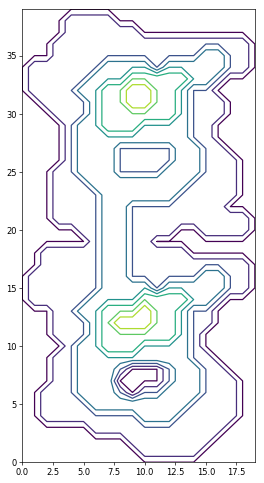

In [2]:
H = np.loadtxt("/Users/hart-davis/Desktop/UIB_class/topo_e3.txt")

fig = plt.figure(figsize=(5, 10), dpi=60)

plt.contour(H)
plt.show()

In [3]:
f = (1.458e-4)*np.sin(60*np.pi/180)

In [4]:
U = np.zeros((H.shape))  #empty arrays 
V = np.zeros((H.shape))  #empty arrays
Z = np.zeros((H.shape))  #empty arrays
Un = np.zeros((H.shape))  #empty arrays 
Vn = np.zeros((H.shape))  #empty arrays
Zn = np.zeros((H.shape))
WX1 = np.zeros((H.shape))
WY1 = np.zeros((H.shape))
WX2 = np.zeros((H.shape))
WY2 = np.zeros((H.shape))

Us = np.zeros((1000,40,20))  #empty arrays 
Vs = np.zeros((1000,40,20))  #empty arrays
Zs = np.zeros((1000,40,20)) 

WX1[:,:] = 10
# WY2[:,:] = 10

g = 9.81    #gravitational acceleration

dx = 1e4
dy = 1e4

f = (1.458e-4)*np.sin(60*np.pi/180) #coriolis force CONVERT  TO RADIANS

r = .003     #friction cooefficient
y_ = 3.2e-6  #wind stress factor
dt = 300
for n in range(0,1000):
    for l in range(1,40-1):
        for j in range(1,20-1):
            if H[l,j]==0 or H[l,j+1]==0:
                Un[l,j] = 0
            else:
                Hu = (H[l,j]+H[l,j+1])/2
                Vu = (V[l,j]+V[l+1,j]+V[l+1,j+1]+V[l,j+1])*0.25  #v at position U
                cor = f*Vu #coriolis parameter term
                pres= -g*Hu*(Z[l,j+1]-Z[l,j])/dx #pgf term
                fri = 1+dt*r*np.sqrt(U[l,j]**2+Vu**2)/Hu**2 #friction term
                wind =  y_*WX1[l,j]*np.sqrt(WX1[l,j]**2+WY1[l,j]**2)  #wind
                Un[l,j] = (U[l,j]+dt*(cor+pres+wind))/fri #all together
                
    for l in range(1,40-1):
        for j in range(1,20-1):           
            if H[l,j]==0 or H[l-1,j]==0:
                Vn[l,j] = 0
            else:
                Hv = (H[l,j]+H[l-1,j])/2
                Uv = (U[l,j-1]+U[l,j]+U[l-1,j]+U[l-1,j-1])*0.25
                cor = -f*Uv
                pres= -g*Hv*(Z[l,j]-Z[l-1,j])/dy
                fri = 1+dt*r*np.sqrt(V[l,j]**2+Uv**2)/Hv**2
                wind =  y_*WY1[l,j]*np.sqrt(WX1[l,j]**2+WY1[l,j]**2)
                Vn[l,j] = (V[l,j]+dt*(cor+pres+wind))/fri
        
    for l in range(1,40-1):
        for j in range(1,20-1):           
            if H[l,j]==0:
                Zn[l,j] = 0
            else:
                Zn[l,j] = Z[l,j]+(-(Un[l,j]-Un[l,j-1])/dx-(Vn[l+1,j]-Vn[l,j])/dy)*dt
    U = Un
    V = Vn
    Z = Zn
    Us[n] = Un
    Vs[n] = Vn
    Zs[n] = Zn


In [5]:
def surface_plot3D(X, Y, eta,):
    """Function that takes input 1D coordinate arrays x, y and 2D array
    array psi. Then plots psi as a surface in 3D space on a meshgrid."""
    fig = plt.figure(figsize = (11, 7))
    ax = Axes3D(fig)
    ax.set_zlim(-400,10)
    surf = ax.plot_surface(X, Y, eta, rstride = 1, cstride = 1,
        cmap = plt.cm.Spectral, linewidth = 0, antialiased = True)
    ax.set_title("Surface elevation $\eta$", fontname = "serif", fontsize = 17)
    ax.set_xlabel("x [m]", fontname = "serif", fontsize = 16)
    ax.set_ylabel("y [m]", fontname = "serif", fontsize = 16)
    ax.set_zlabel("Surface elevation [m]", fontname = "serif", fontsize = 16)
    plt.colorbar(surf)
    plt.show()

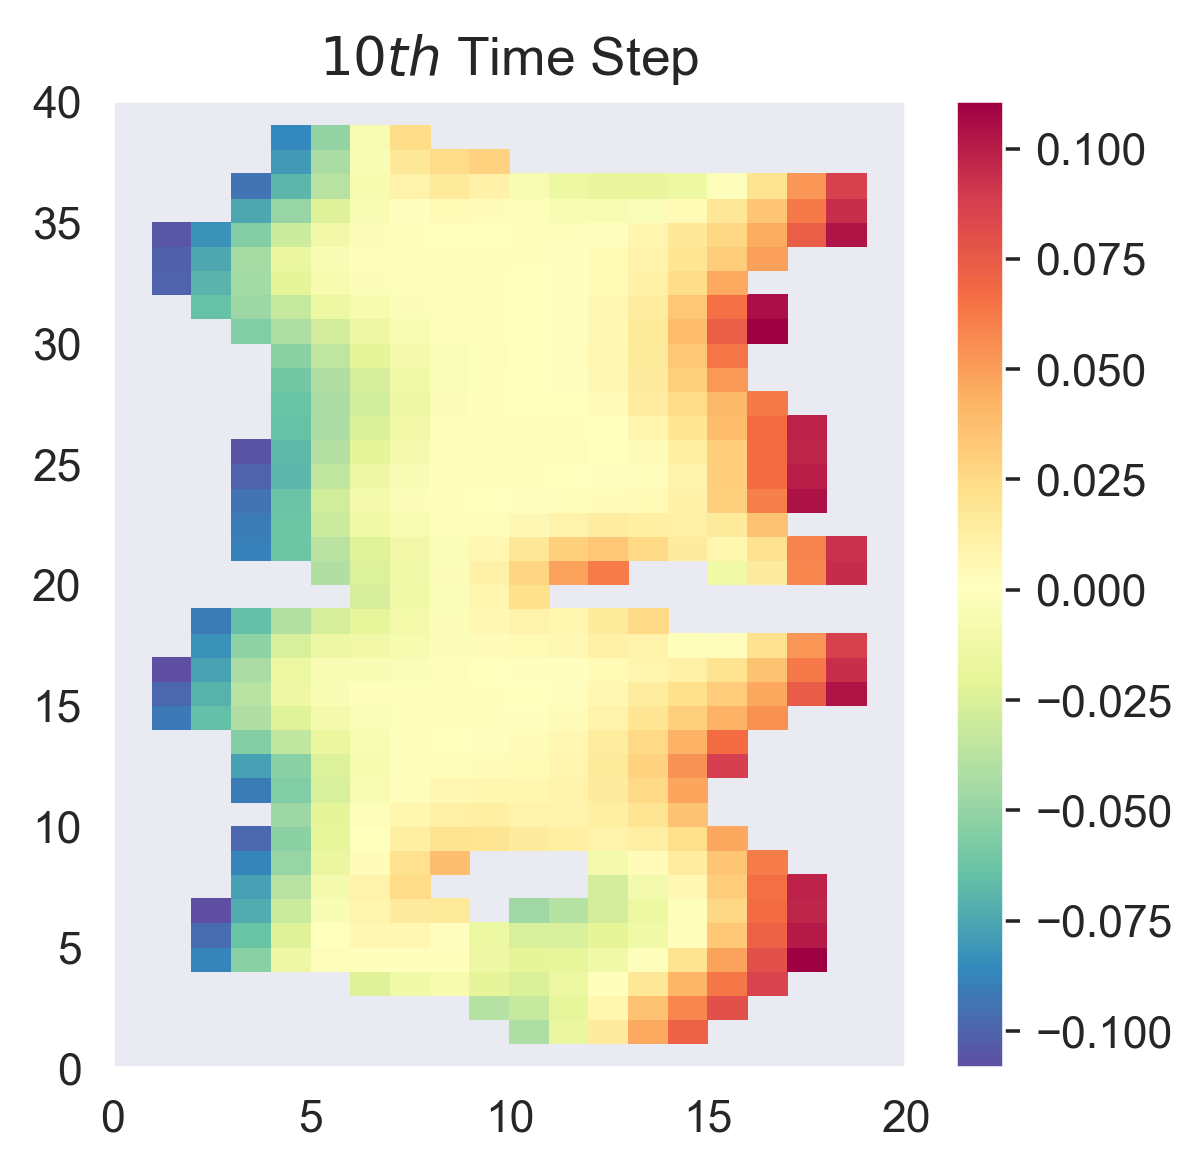

In [118]:
cmap = plt.cm.Spectral
fig = plt.figure(figsize = (4, 4), dpi=320)
Zs[(Zs==0.)] = np.nan
plt.title("$10th$ Time Step")
plt.pcolormesh(Zs[10],cmap=plt.cm.Spectral_r)
plt.colorbar()

In [24]:
nx = np.linspace(0,1e4,20)
ny = np.linspace(0,1e4,40)

xx,yy=np.meshgrid(nx,ny)

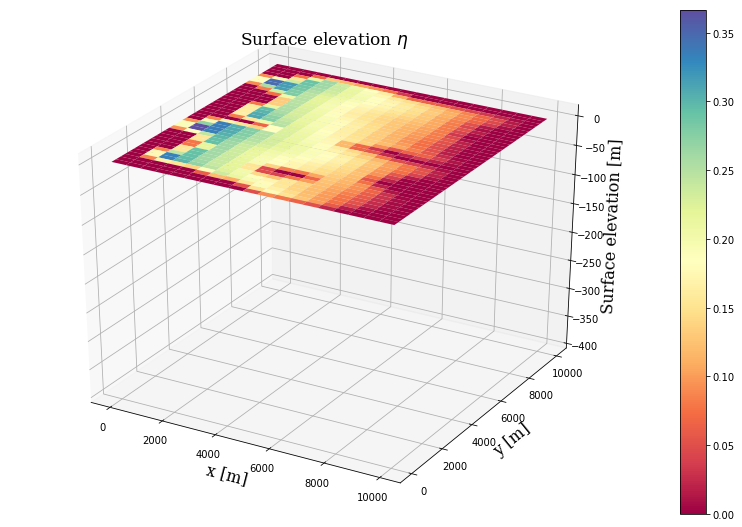

In [7]:
surface_plot3D(xx, yy, Zs[-1],)

In [110]:
from matplotlib import animation
def eta_animation3D(X, Y, eta_list, frame_interval, filename):
    fig = plt.figure(figsize = (8, 8), facecolor = "white")
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, eta_list[0], cmap = plt.cm.RdBu_r)

    def update_surf(num):
        ax.clear()
        surf = ax.plot_surface(X/1000, Y/1000, eta_list[num], cmap = plt.cm.RdBu_r)
        ax.set_title("Surface elevation $\eta(x,y,t)$ after $t={:.2f}$ hours".format(
            num*frame_interval), fontname = "serif", fontsize = 19, y=1.04)
        ax.set_xlabel("x [km]", fontname = "serif", fontsize = 14)
        ax.set_ylabel("y [km]", fontname = "serif", fontsize = 14)
        ax.set_zlabel("$\eta$ [m]", fontname = "serif", fontsize = 16)
        ax.set_xlim(X.min()/1000, X.max()/1000)
        ax.set_ylim(Y.min()/1000, Y.max()/1000)
        ax.set_zlim(eta_list.min(),eta_list.max())

        plt.tight_layout()
        return surf,

    anim = animation.FuncAnimation(fig, update_surf,
        frames = len(eta_list), interval = 10, blit = False)
    mpeg_writer = animation.FFMpegWriter(fps = 24, bitrate = 10000,
        codec = "libx264", extra_args = ["-pix_fmt", "yuv420p"])
    anim.save("{}.mp4".format(filename), writer = mpeg_writer)
    return anim    # Need to return anim object to see the animation

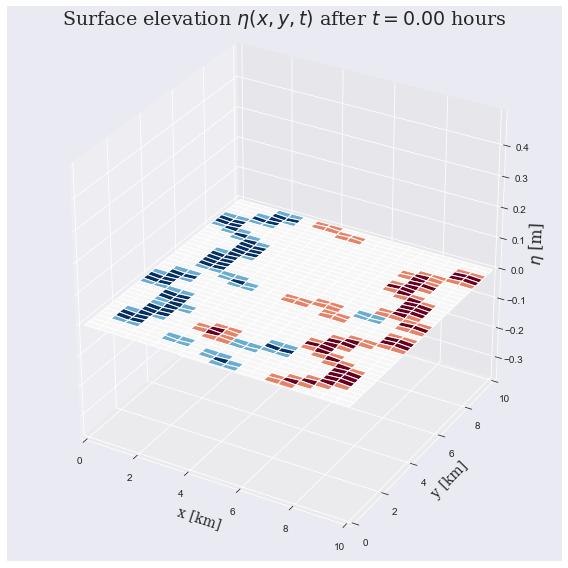

In [111]:
eta_animation3D(xx,yy,Zs,1000,'mt4_a')

In [106]:
Uss = Us/ np.sqrt(Us**2 + Vs**2);
Vss = Vs/ np.sqrt(Us**2 + Vs**2);

/Users/hart-davis/miniconda3/envs/py3_parcels/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/hart-davis/miniconda3/envs/py3_parcels/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/hart-davis/miniconda3/envs/py3_parcels/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/hart-davis/miniconda3/envs/py3_parcels/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


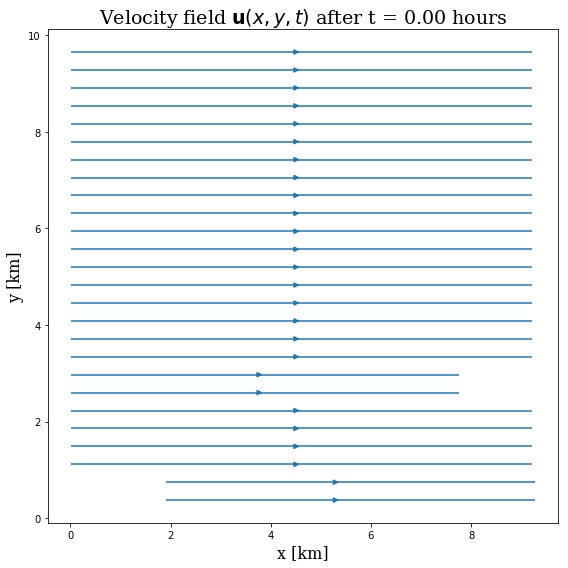

In [40]:
def velocity_animation(X, Y, u_list, v_list, frame_interval, filename):
    """Function that takes in the domain x, y (2D meshgrids) and a lists of 2D arrays
    u_list, v_list and creates an quiver animation of the velocity field (u, v). To get
    updating title one also need specify time step dt between each frame in the simulation,
    the number of time steps between each eta in eta_list and finally, a filename for video."""
    fig, ax = plt.subplots(figsize = (8, 8), facecolor = "white")
    plt.title("Velocity field $\mathbf{u}(x,y)$ after 0.0 days", fontname = "serif", fontsize = 19)
    plt.xlabel("x [km]", fontname = "serif", fontsize = 16)
    plt.ylabel("y [km]", fontname = "serif", fontsize = 16)
    q_int = 3
    Q = ax.streamplot(X[::q_int, ::q_int]/1000.0, Y[::q_int, ::q_int]/1000.0,
                  u_list[0][::q_int,::q_int], v_list[0][::q_int,::q_int],)
    #qk = plt.quiverkey(Q, 0.9, 0.9, 0.001, "0.1 m/s", labelpos = "E", coordinates = "figure")

    # Update function for quiver animation.
    def update_quiver(num):
        u = u_list[num]
        v = v_list[num]
        ax.set_title("Velocity field $\mathbf{{u}}(x,y,t)$ after t = {:.2f} hours".format(
            num*frame_interval/3600), fontname = "serif", fontsize = 19)
        return Q,

    anim = animation.FuncAnimation(fig, update_quiver,
        frames = len(u_list), interval = 10, blit = False)
    mpeg_writer = animation.FFMpegWriter(fps = 24, bitrate = 10000,
        codec = "libx264", extra_args = ["-pix_fmt", "yuv420p"])
    fig.tight_layout()
    anim.save("{}.mp4".format(filename), writer = mpeg_writer)
    return anim    # Need to return anim object to see the animation
velocity_animation(xx,yy,Us,Vs, 1000,'velocity')

In [108]:
def eta_animation2D(X, Y, eta_list, frame_interval, filename):
    fig = plt.figure(figsize = (8, 8), facecolor = "white")
    ax = fig.add_subplot(111)

    surf = ax.pcolormesh(X, Y, eta_list[0], cmap = plt.cm.RdBu_r)

    def update_surf(num):
        ax.clear()
        surf = ax.pcolormesh(X/1000, Y/1000, eta_list[num], cmap = plt.cm.RdBu_r,vmin=-0.5,vmax=0.5)
        ax.set_title("Surface elevation $\eta(x,y,t)$ after $t={:.2f}$ hours".format(
            num*frame_interval), fontname = "serif", fontsize = 19, y=1.04)
        ax.set_xlabel("x [km]", fontname = "serif", fontsize = 14)
        ax.set_ylabel("y [km]", fontname = "serif", fontsize = 14)
        ax.set_xlim(X.min()/1000, X.max()/1000)
        ax.set_ylim(Y.min()/1000, Y.max()/1000)
        plt.tight_layout()
        return surf,

    anim = animation.FuncAnimation(fig, update_surf,
        frames = len(eta_list), interval = 10, blit = False)
    mpeg_writer = animation.FFMpegWriter(fps = 24, bitrate = 10000,
        codec = "libx264", extra_args = ["-pix_fmt", "yuv420p"])
    anim.save("{}.mp4".format(filename), writer = mpeg_writer)
    return anim    # Need to return anim object to see the animation

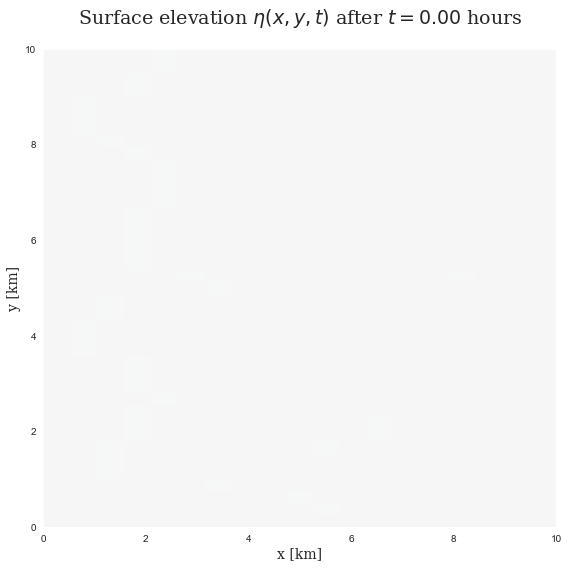

In [109]:
eta_animation2D(xx,yy,Zs,1000,'MT4_a')

/Users/hart-davis/miniconda3/envs/py3_parcels/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


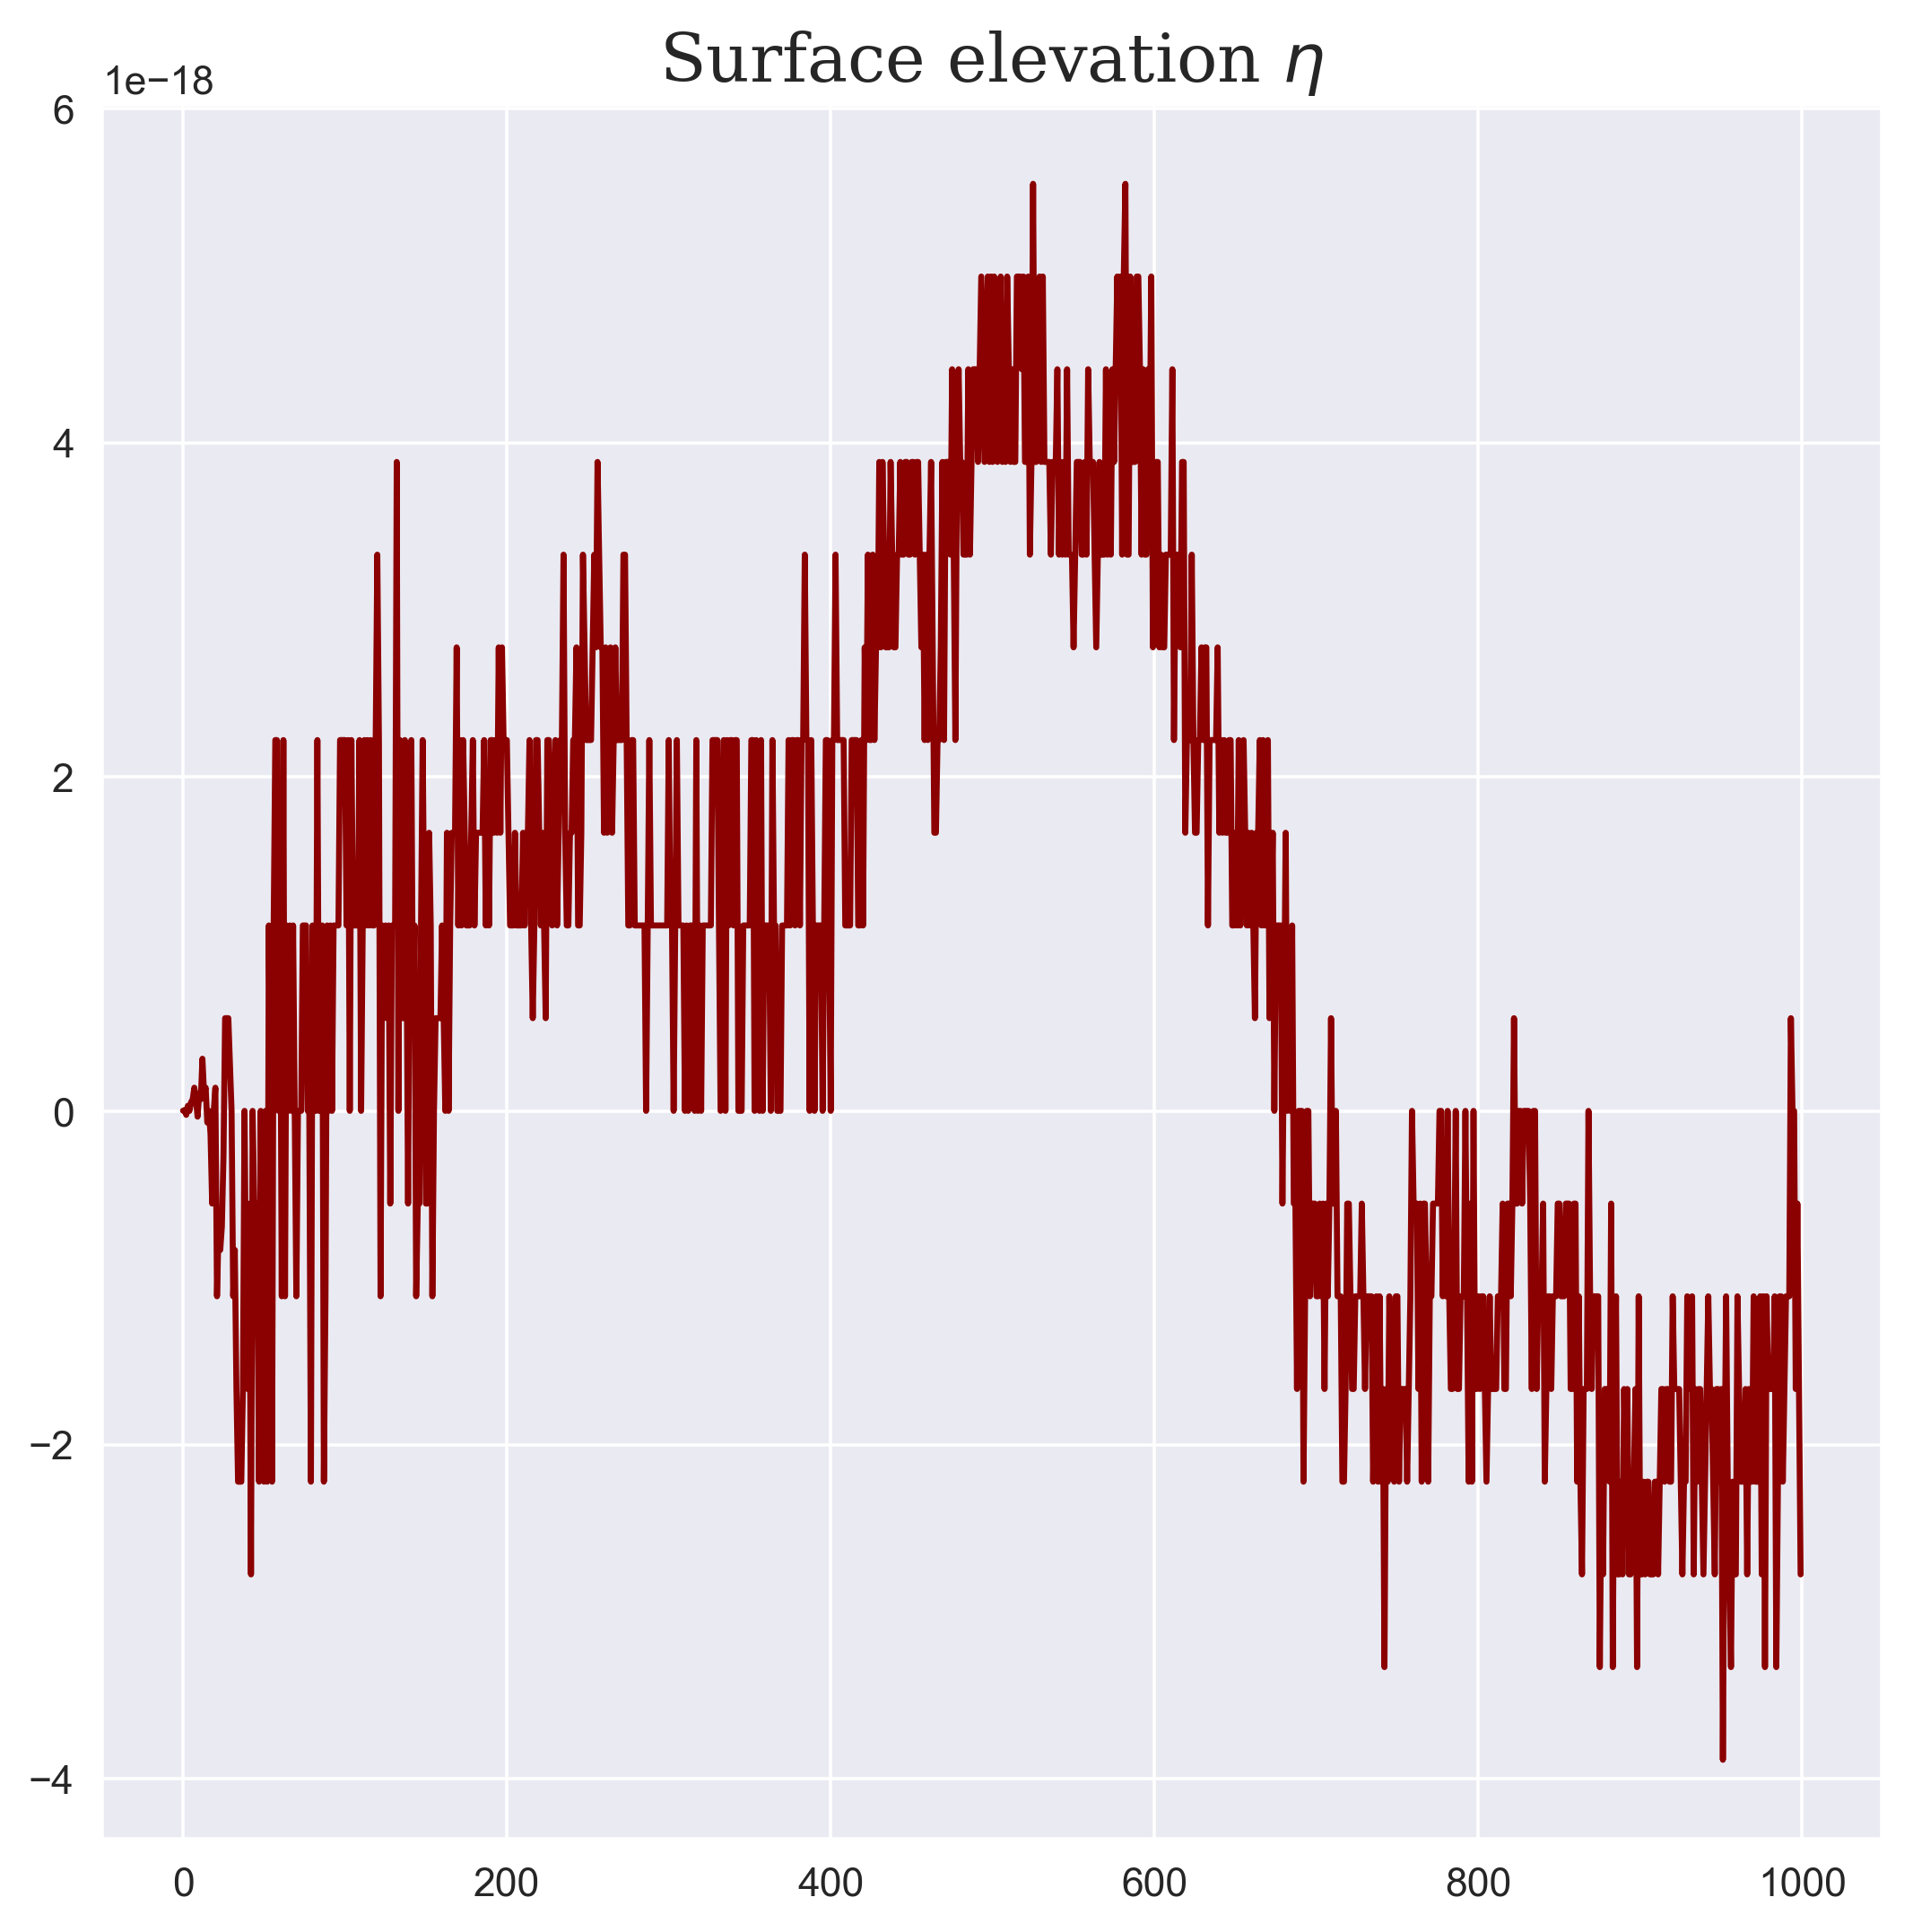

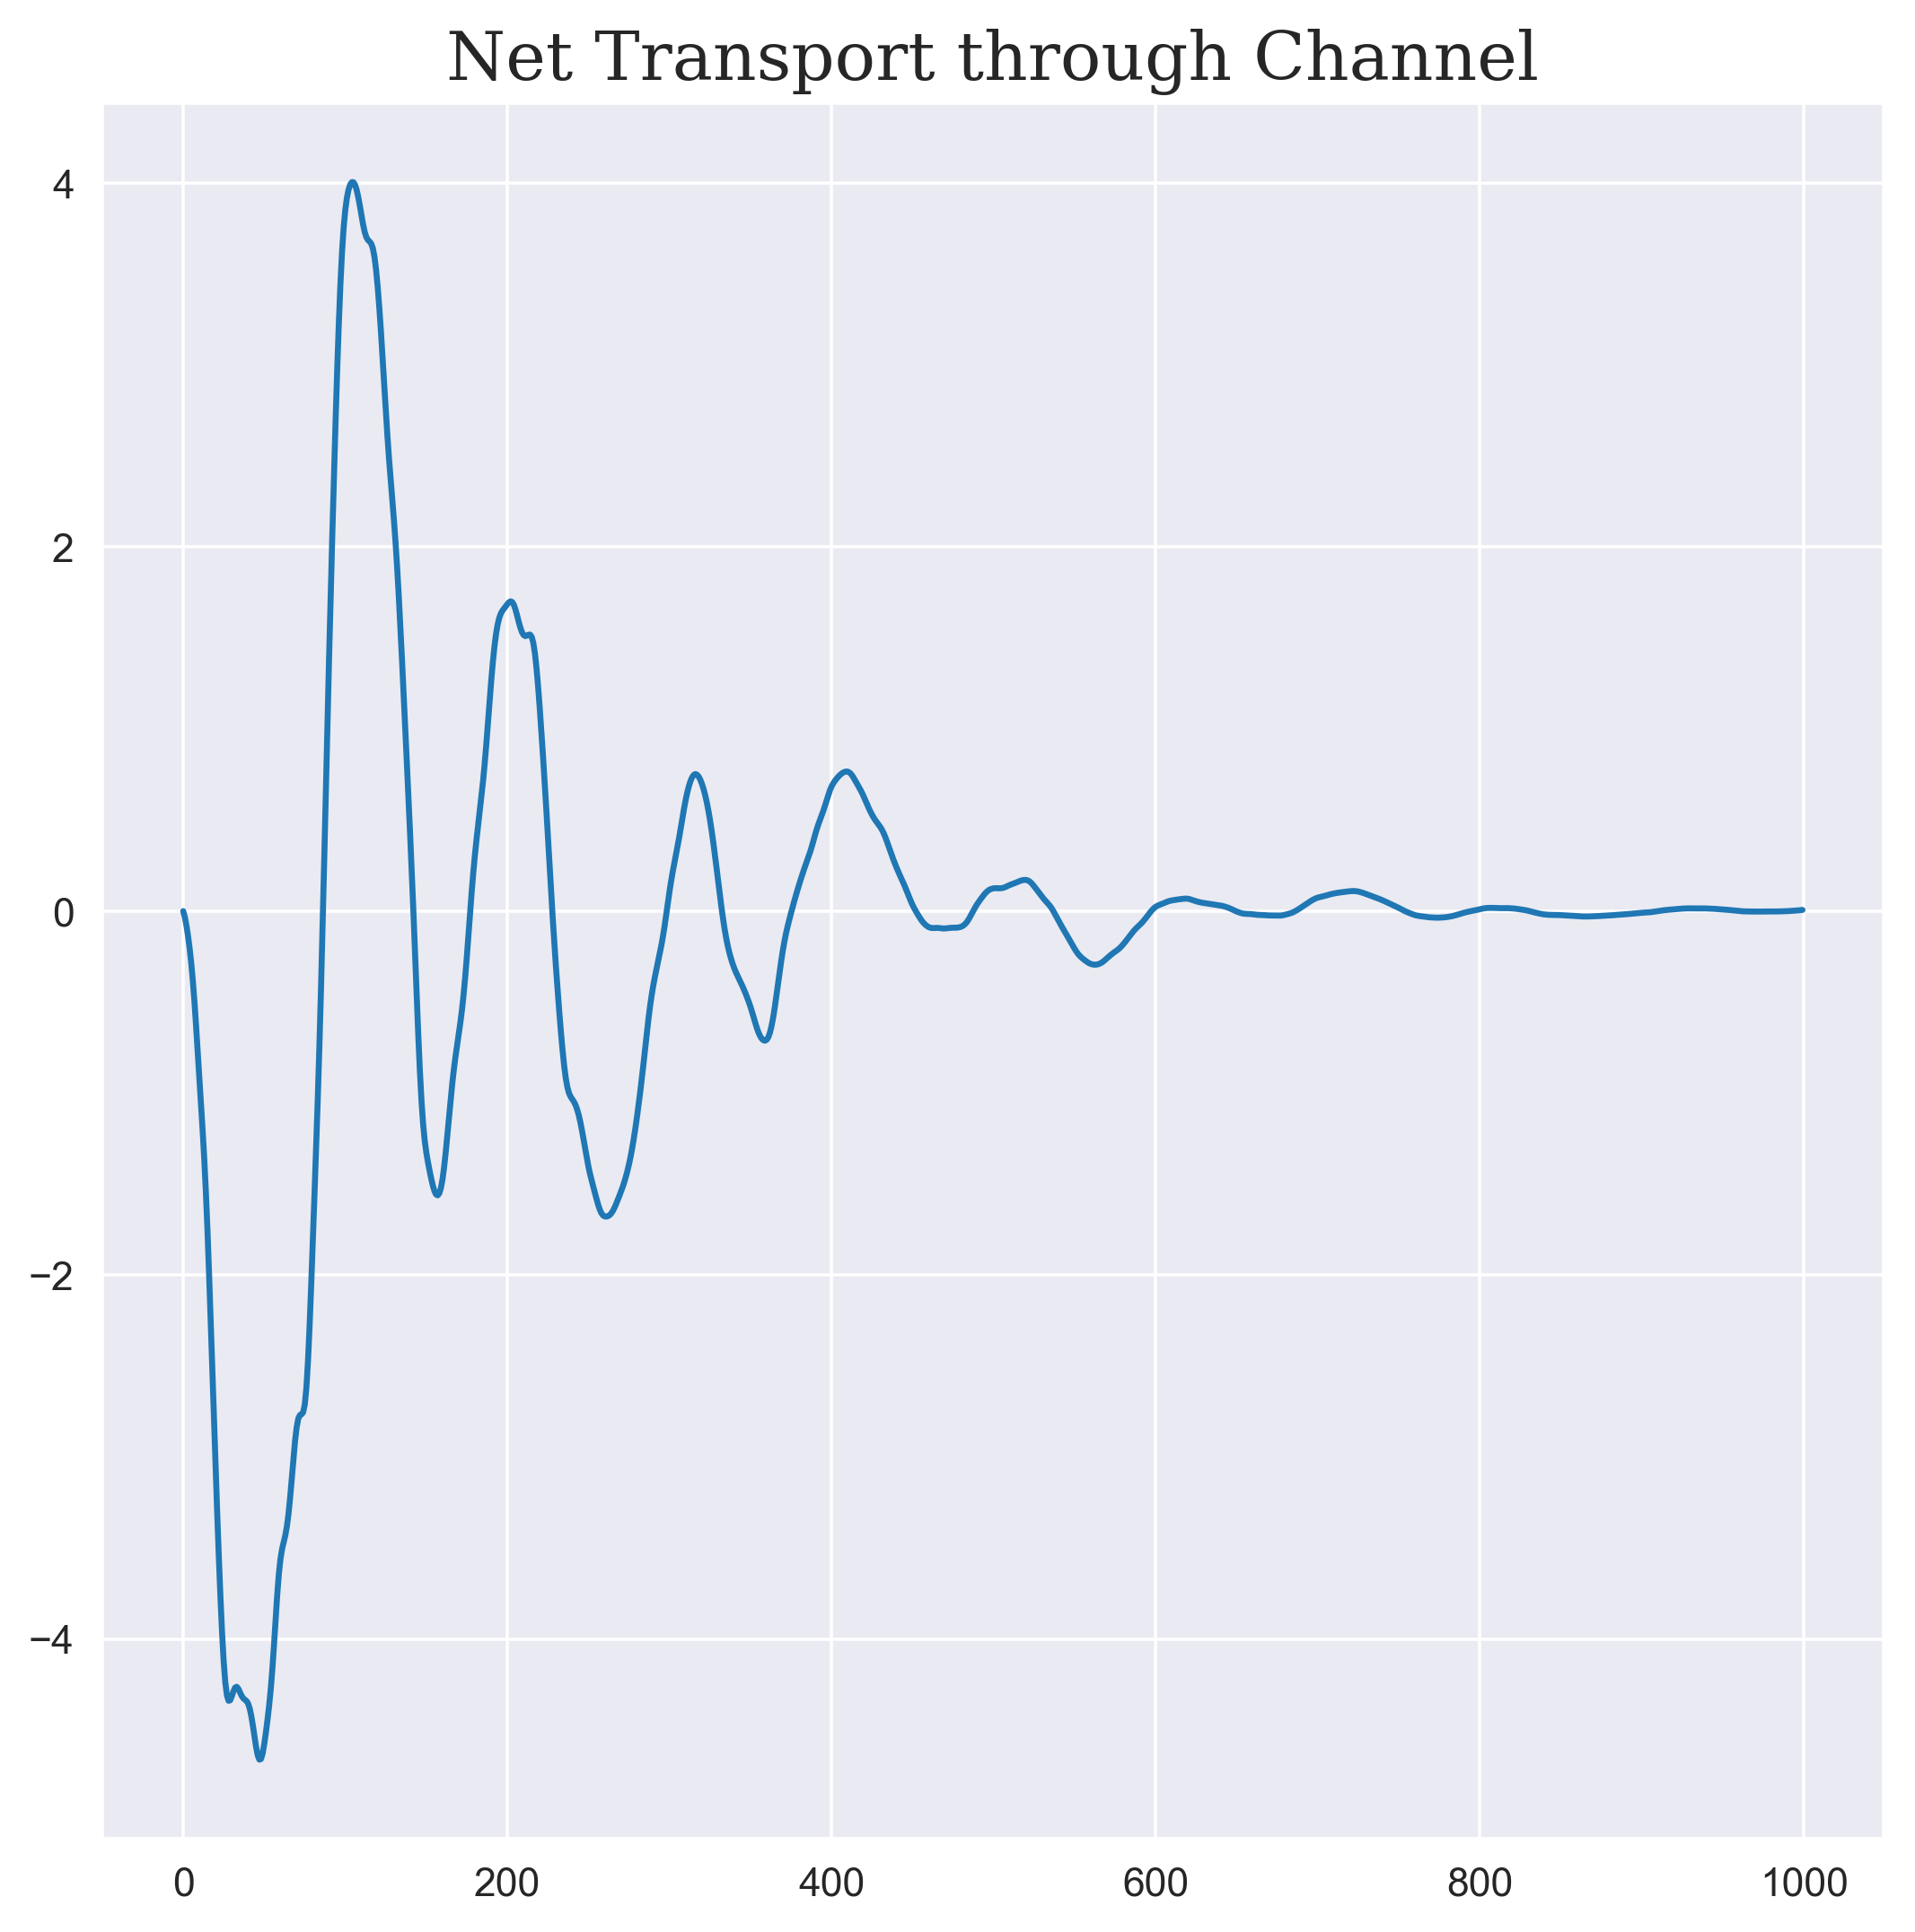

Max elevation =  0.23823254038471808
Mean elevation =  -2.7755575615628915e-18
Stable time step =  38
Time step in hours =  3.1666666666666665 hours


In [121]:
zn = np.zeros(1000)
for i in range(0,1000):
    zn[i]=Zs[i].mean()
fig = plt.figure(figsize = (8, 8), dpi=320)

sns.set_style("darkgrid")
sns.lineplot(data=zn,c='darkred')
plt.title("Surface elevation $\eta$", fontname = "serif", fontsize = 17)
plt.show()
fig = plt.figure(figsize = (8, 8), dpi=320)

plt.title("Net Transport through Channel", fontname = "serif", fontsize = 17)
sns.lineplot(data=np.sum(Vs[:,19,:],axis=1))
plt.show()

print ("Max elevation = ", Zn.max())
print ("Mean elevation = ", Zn.mean())
s = np.zeros(1000)

for i in range(0,1000-1):
    ss = np.sqrt((zn[i] - zn[i+1])**2)
    if ss < 10e-7:
        s[i] = 0.0
    else:
        s[i]=ss

print ("Stable time step = ", np.where(s==0.0)[0][38:][0])
print ("Time step in hours = ", np.where(s==0.0)[0][38:][0]*300/3600, "hours")

In [84]:
np.abs(Vn[20,:])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.99395954, 1.64826965, 1.59827235, 1.14083185,
       1.10441929, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [22]:
fig = plt.figure(figsize = (8, 8), dpi=320)


Volin = np.sum(Vn[19,:]+np.abs(Vn[19,:]))*0.5*dx
V = dx*dy*np.sum(H[19:,:])

print("Flushing time in seconds :", V/Volin)
print("Flushing time in days :", V/Volin/86400)
print("Flushing time in time steps :", V/Volin/300)

Flushing time in seconds : 10163765.113004014
Flushing time in days : 117.63617028939831
Flushing time in time steps : 33879.21704334671


<Figure size 2560x2560 with 0 Axes>

In [28]:
Vs.shape

(1000, 40, 20)

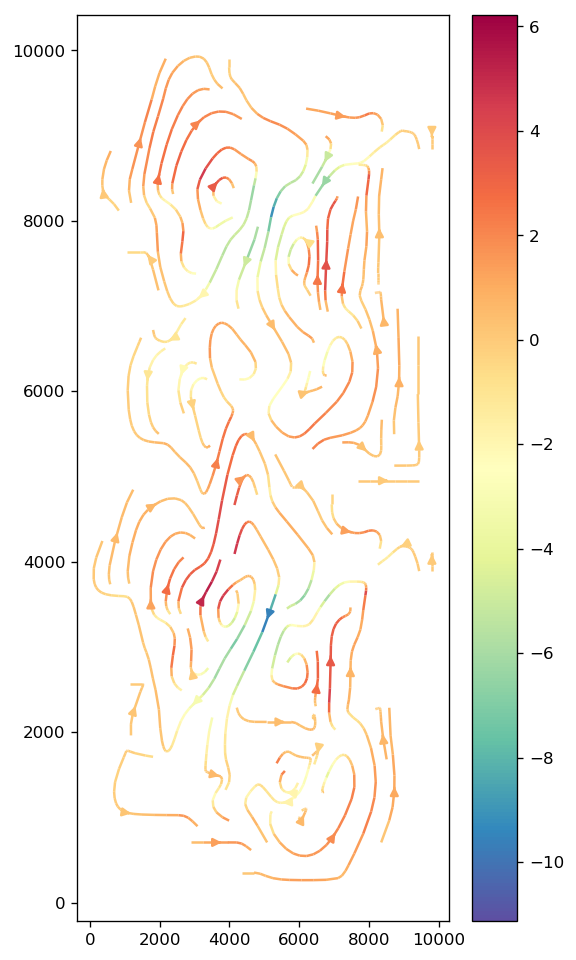

In [44]:
fig = plt.figure(figsize=(5, 10), dpi=120)
plt.streamplot(xx,yy,Un,Vn,color=Un+Vn,cmap=plt.cm.Spectral_r)
plt.colorbar()